输出文件
=========

nsga3_hv_sp_history.csv
列为：gen, hv, sp, front_size（front_size 是每代种群的前沿点数）

nsga3_front_solutions.csv：每行一个帕累托解（收益/回撤/得分/持仓数/Sharpe_Proxy）

nsga3_front_holdings.csv：每行一条持仓（solution_id, stock_code, industry, factor_score）

nsga3_front_quality_metrics.csv：HV、SP、front_size 等汇总

nsga3_holdings_max_return.csv

nsga3_holdings_max_score.csv

nsga3_holdings_min_risk.csv

nsga3_holdings_sharpe.csv

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import random

# 忽略潜在的警告|
warnings.filterwarnings('ignore')


# ================================
# 【新增】固定归一化基准：随机可行解 min/max
# ================================
# def estimate_minmax_from_random_feasible(
#     optimizer,
#     n_samples: int = 10000,
#     seed: int = 123,
# ):
#     """
#     用随机生成的“可行解”估计 min/max（在全最小化空间）
#     返回: (min_ref, max_ref)
#       - min_ref/max_ref: shape (3,)
#     """
#     rng = np.random.default_rng(seed)
#
#     objs_list = []
#     tries = 0
#     # 为避免极端情况下卡住，设一个上限
#     max_tries = n_samples * 30
#
#     while len(objs_list) < n_samples and tries < max_tries:
#         tries += 1
#
#         z = np.zeros(optimizer.n_stocks, dtype=int)
#         k = int(rng.integers(Config.K_MIN, Config.K_MAX + 1))
#         idx = rng.choice(optimizer.n_stocks, size=k, replace=False)
#         z[idx] = 1
#
#         z = optimizer.repair(z)
#         obj = optimizer.calculate_objectives(z)
#
#         # 跳过惩罚解（你代码里用 -999 / 999 / -999）
#         if obj[0] <= -900 or obj[1] >= 900 or obj[2] <= -900:
#             continue
#
#         objs_list.append(obj)
#
#     if len(objs_list) < max(100, n_samples // 10):
#         raise RuntimeError(f"基准样本生成太少：仅 {len(objs_list)} 个（请调大 max_tries 或放宽约束/数据缺失惩罚）")
#
#     base_objs = np.array(objs_list, dtype=float)
#     base_min_objs = np.column_stack([-base_objs[:, 0], base_objs[:, 1], -base_objs[:, 2]])
#
#     min_ref = np.min(base_min_objs, axis=0)
#     max_ref = np.max(base_min_objs, axis=0)
#
#     return min_ref, max_ref
#
#
# def normalize_with_fixed_minmax(X: np.ndarray, x_min: np.ndarray, x_max: np.ndarray, eps: float = 1e-12) -> np.ndarray:
#     denom = np.maximum(x_max - x_min, eps)
#     Xn = (X - x_min) / denom
#     # 为了让 HV 体积统计稳定：裁剪到 [0,1]
#     return np.clip(Xn, 0.0, 1.0)


# ==========================================
# 第一部分：数据加载与预处理 (Data Preprocessing)
# 功能：读取CSV，过滤时间窗口，对齐数据，将行业转为数字编码
# ==========================================
def load_and_process_data():
    print("【步骤1】正在读取并处理数据...")

    # --- 1. 读取日收益率数据 (源头修复：指定 code 为字符串) ---
    try:
        # dtype={'code': str} 确保 '000001' 读进来还是 '000001'
        df_ret = pd.read_csv("stock_returns_daily.csv", dtype={'code': str})
    except FileNotFoundError:
        raise FileNotFoundError("缺失文件: stock_returns_daily.csv")

    df_ret['timestamps'] = pd.to_datetime(df_ret['timestamps'])

    # 过滤时间范围 (2024-12-02 到 2025-12-26)
    start_date = "2024-12-02"
    end_date = "2025-12-26"
    mask = (df_ret['timestamps'] >= start_date) & (df_ret['timestamps'] <= end_date)
    df_ret = df_ret.loc[mask]

    # --- 关键修复：ChangePCT 是百分数(%) -> 小数比率 ---
    df_ret["ChangePCT"] = pd.to_numeric(df_ret["ChangePCT"], errors="coerce") / 100.0

    # --- 学术更稳：极端/不可能值直接置空，不参与当日等权 ---
    # r <= -100% 会导致 (1+r)<=0，净值穿0；属于数据异常/口径异常
    df_ret.loc[df_ret["ChangePCT"] <= -0.999999, "ChangePCT"] = np.nan

    # 转换为矩阵：行=日期，列=股票代码
    df_ret['code'] = df_ret['code'].astype(str)
    returns_matrix = df_ret.pivot(index='timestamps', columns='code', values='ChangePCT')
    returns_matrix = returns_matrix.fillna(0.0)  # 填充缺失数据

    # --- 2. 读取因子得分数据 (源头修复) ---
    try:
        df_scores = pd.read_csv("csi300_3factor_scores_winsorized.csv", dtype={'code': str})
    except FileNotFoundError:
        raise FileNotFoundError("缺失文件: csi300_3factor_scores_winsorized.csv")

    df_scores['code'] = df_scores['code'].astype(str)
    df_scores = df_scores.drop_duplicates(subset=['code']).set_index('code')

    # --- 3. 读取行业分类数据 (源头修复) ---
    try:
        df_industry = pd.read_csv("csi300_with_industry_2022_2025.csv", dtype={'code': str})
    except FileNotFoundError:
        raise FileNotFoundError("缺失文件: csi300_with_industry_2022_2025.csv")

    df_industry['code'] = df_industry['code'].astype(str)
    df_industry = df_industry.drop_duplicates(subset=['code']).set_index('code')

    # 保存一份代码到名称的映射，方便后续展示
    # (如果有 name 列的话)
    if 'name' in df_industry.columns:
        code_to_name = df_industry['name'].to_dict()
    else:
        code_to_name = {}

    # 4. 数据对齐 (取三者交集)
    valid_codes = returns_matrix.columns
    valid_codes = valid_codes.intersection(df_scores.index)
    valid_codes = valid_codes.intersection(df_industry.index)

    print(f"   - 时间范围: {start_date} 至 {end_date}")
    print(f"   - 有效股票数量: {len(valid_codes)}")

    # 提取最终数据
    returns_matrix = returns_matrix[valid_codes]
    scores_series = df_scores.loc[valid_codes, 'final_score']
    industry_raw = df_industry.loc[valid_codes, 'sw_level1']

    # 将行业名称映射为整数 ID (0, 1, 2...)
    industry_codes, industry_uniques = pd.factorize(industry_raw)
    sectors_series = pd.Series(industry_codes, index=valid_codes)

    print(f"   - 覆盖行业数量: {len(industry_uniques)}")

    return returns_matrix, scores_series, sectors_series, valid_codes, industry_uniques, code_to_name


# ================================
# 【新增】Pareto/HV/SP 工具函数
# ================================
def nondominated_mask(min_objs: np.ndarray) -> np.ndarray:
    """
    min_objs: (M, d) 全部目标均为“越小越好”
    返回: (M,) True 表示非支配解
    """
    M = min_objs.shape[0]
    mask = np.ones(M, dtype=bool)
    for i in range(M):
        if not mask[i]:
            continue
        dominates_i = np.all(min_objs <= min_objs[i], axis=1) & np.any(min_objs < min_objs[i], axis=1)
        dominates_i[i] = False
        if np.any(dominates_i):
            mask[i] = False
    return mask


def normalize_to_unit_box(X: np.ndarray, eps: float = 1e-12):
    x_min = np.min(X, axis=0)
    x_max = np.max(X, axis=0)
    denom = np.maximum(x_max - x_min, eps)
    Xn = (X - x_min) / denom
    return Xn, x_min, x_max


def spacing_metric(front_norm: np.ndarray) -> float:
    K = front_norm.shape[0]
    if K < 2:
        return 0.0
    diffs = front_norm[:, None, :] - front_norm[None, :, :]
    dist = np.sqrt(np.sum(diffs * diffs, axis=2))
    np.fill_diagonal(dist, np.inf)
    d_i = np.min(dist, axis=1)
    d_mean = np.mean(d_i)
    return float(np.sqrt(np.sum((d_i - d_mean) ** 2) / (K - 1)))


def hypervolume_mc(front_norm_min: np.ndarray, ref: np.ndarray, n_samples: int = 20000, seed: int = 42) -> float:
    """
    Monte Carlo 估计 HV（越大越好）
    front_norm_min: 已归一化，且全最小化（越小越好）
    ref: 参考点（应比 front 更差），例如 [1.1, 1.1, 1.1]
    """
    rng = np.random.default_rng(seed)
    d = front_norm_min.shape[1]
    samples = rng.random((n_samples, d)) * ref
    dominated = np.any(np.all(front_norm_min[None, :, :] <= samples[:, None, :], axis=2), axis=1)
    return float(dominated.mean() * np.prod(ref))


# ==========================================
# 第二部分：算法配置 (Configuration)
# 功能：定义超参数、约束条件及参考点生成逻辑
# ==========================================
class Config:
    # 【新增】固定归一化基准配置
    BASELINE_SAMPLES = 10000  # 建议 5k~20k；越大越稳但更慢
    BASELINE_SEED = 14

    # 【新增】HV/SP 计算配置
    HV_REF = np.array([1.1, 1.1, 1.1])  # 归一化后参考点（越大越“差”）
    HV_SAMPLES = 100000  # Monte Carlo 采样数（越大越稳，但更慢）
    HV_SEED = 42  # 固定随机种子，便于复现实验曲线

    # 进化参数
    N_POP = 100  # 种群规模
    N_GEN = 200  # 迭代代数 (建议 100-200)
    PC = 0.9  # 交叉概率
    PM = 0.05  # 变异概率

    # 约束条件
    K_MIN = 10  # 最小持仓数
    K_MAX = 30  # 最大持仓数
    MIN_SECTORS = 5  # 最小行业覆盖数
    MAX_SECTOR_RATIO = 0.25  # 单行业占比上限 (25%)

    # --- 学术更稳：组合日收益的有效覆盖率阈值 ---
    # 例如 0.8 表示：每天至少 80% 的持仓股票需要有收益数据，否则该组合判无效（惩罚）
    MIN_VALID_RATIO = 0.80

    # --- 学术更稳：Winsorize 日收益，防止极端点主导目标（可选） ---
    # 例如限制在 [-20%, +20%]，你也可以根据市场环境调整
    RET_CLIP = (-0.20, 0.20)

    # 目标函数参数
    TRADING_DAYS = 250  # 年化系数

    # 权重配置 (用于距离计算)
    # 顺序: [年化收益, 最大回撤, 因子得分]
    W_DIST = np.array([0.3, 0.4, 0.3])


# ==========================================
# 第三部分：核心算法实现 (NSGA-III Core)
# 功能：实现目标计算、修复算子、交叉变异及选择逻辑
# ==========================================
class NSGA3_Optimizer:
    def __init__(self, returns, scores, sectors):
        self.returns = returns.values  # (T, N)
        self.scores = scores.values  # (N,)
        self.sectors = sectors.values  # (N,)
        self.n_stocks = len(scores)

        # 生成风险分层参考点
        self.ref_points = self._generate_risk_stratified_refs()

        # 记录历史 (保留您的CSV输出需求)
        self.hv_sp_history = []

        # 【新增】基因保护机制相关
        # protected_mask[i, j] = True 表示第 i 个个体的第 j 只股票是“优质核心”，需保护
        self.protected_masks = np.zeros((Config.N_POP, self.n_stocks), dtype=bool)
        self.window_size = 5     # 滑动窗口大小 (5只股票)
        self.protect_freq = 10   # 每10代更新一次保护名单

        # 【新增】计算个股质量分级 (0:劣质, 1:普通, 2:优质)
        # 这一步只在初始化做一次，不影响迭代速度
        self.stock_tiers = self._calculate_stock_quality_tiers()

    def _calculate_stock_quality_tiers(self):
        """
        【新增】基于因子分和波动率，给股票分级
        Tier 2 (Elite): 高分低波 (前 30%)
        Tier 0 (Weak):  低分高波 (后 30%)
        Tier 1 (Mid):   中间 (40%)
        """
        # 1. 计算个股历史波动率 (风险代理)
        # axis=0 对时间维度求标准差
        volatility = np.nanstd(self.returns, axis=0)
        # 填充 nan (防止报错)
        volatility[np.isnan(volatility)] = np.nanmean(volatility)

        # 2. 归一化 (越小越好 -> 转为越大越好)
        # 分数归一化 (0-1)
        s_min, s_max = np.min(self.scores), np.max(self.scores)
        norm_score = (self.scores - s_min) / (s_max - s_min + 1e-9)

        # 波动率归一化 (0-1)，注意：波动率越小越好，所以取反
        v_min, v_max = np.min(volatility), np.max(volatility)
        norm_vol = 1 - (volatility - v_min) / (v_max - v_min + 1e-9)

        # 3. 综合质量分 = 0.7 * 因子分 + 0.3 * 低波分
        # (权重可调，假设我们更看重因子)
        quality_score = 0.7 * norm_score + 0.3 * norm_vol

        # 4. 分位数分级
        tiers = np.ones(self.n_stocks, dtype=int) # 默认为 1 (普通)

        th_high = np.percentile(quality_score, 70) # Top 30%
        th_low = np.percentile(quality_score, 30)  # Bottom 30%

        tiers[quality_score >= th_high] = 2  # 优质
        tiers[quality_score <= th_low] = 0   # 劣质

        print(f"  [Stock Quality] Elite: {np.sum(tiers==2)}, Mid: {np.sum(tiers==1)}, Weak: {np.sum(tiers==0)}")
        return tiers

    def _generate_risk_stratified_refs(self):
        """生成30个风险分层参考点"""
        refs = []
        # 1. 保守型
        for _ in range(12):
            r = np.array([0.2, 0.6, 0.2]) + np.random.rand(3) * 0.1
            refs.append(r / r.sum())
        # 2. 平衡型
        for _ in range(12):
            r = np.array([0.33, 0.33, 0.33]) + np.random.rand(3) * 0.1
            refs.append(r / r.sum())
        # 3. 激进型
        for _ in range(6):
            if np.random.rand() > 0.5:
                r = np.array([0.6, 0.1, 0.3])
            else:
                r = np.array([0.3, 0.1, 0.6])
            refs.append(r / r.sum())
        return np.array(refs)

    def calculate_objectives(self, z):
        sel_idx = np.where(z == 1)[0]
        # 空解惩罚
        if len(sel_idx) == 0:
            return np.array([-999.0, 999.0, -999.0])

        # 1. 因子得分
        f_score = float(np.mean(self.scores[sel_idx]))

        # 2. 收益与回撤
        # 使用 nanmean 处理停牌/缺失数据
        sel_ret = self.returns[:, sel_idx]
        port_daily_ret = np.nanmean(sel_ret, axis=1)

        # 兜底检查
        if np.all(np.isnan(port_daily_ret)):
            return np.array([-999.0, 999.0, -999.0])

        # 净值计算 (Log累加更稳定)
        log_nav = np.cumsum(np.log1p(port_daily_ret))
        nav = np.exp(log_nav)

        # 年化收益
        ann_ret = nav[-1] ** (Config.TRADING_DAYS / len(nav)) - 1

        # 最大回撤
        peak = np.maximum.accumulate(nav)
        dd = (peak - nav) / peak
        max_dd = float(np.max(dd))

        return np.array([ann_ret, max_dd, f_score])

    def _calculate_window_metrics(self, indices):
        """
        【新增】计算种子窗口的指标 (局部评估)
        用于判断这 5-10 只股票组成的小组合是否足够优秀
        """
        f_score = float(np.mean(self.scores[indices]))

        sel_ret = self.returns[:, indices]
        port_daily_ret = np.nanmean(sel_ret, axis=1)

        # 简单计算年化收益和波动率 (作为风险代理，比回撤计算快)
        ann_ret = np.mean(port_daily_ret) * Config.TRADING_DAYS
        ann_vol = np.std(port_daily_ret) * np.sqrt(Config.TRADING_DAYS)

        # 返回: [收益, 风险(波动率), 得分]
        return ann_ret, ann_vol, f_score

    def update_protected_fragments(self, pop):
        """
        【新增】核心思想实现：识别并锁定优质片段
        步骤 1 & 3: 滑动窗口扫描，标记优质子集
        """
        # 重置保护掩码
        self.protected_masks = np.zeros((len(pop), self.n_stocks), dtype=bool)

        # 收集所有窗口的指标以确定相对阈值
        all_window_metrics = []
        window_mapping = [] # (pop_idx, stock_indices)

        for i, ind in enumerate(pop):
            sel_idx = np.where(ind == 1)[0]
            if len(sel_idx) < self.window_size:
                continue

            # 滑动窗口 (Step 1)
            # 假设 sel_idx 是 [0, 5, 12, ...]，窗口就是 [0,5,12,15,20]
            for start in range(len(sel_idx) - self.window_size + 1):
                window_indices = sel_idx[start : start + self.window_size]

                ret, vol, score = self._calculate_window_metrics(window_indices)
                all_window_metrics.append([ret, vol, score])
                window_mapping.append((i, window_indices))

        if not all_window_metrics:
            return

        # 确定动态阈值 (Top 20% 收益，Bottom 20% 风险，Top 20% 得分)
        # 只要满足其中两个条件，或者综合表现优异，即判定为“非支配窗口”
        metrics = np.array(all_window_metrics)

        th_ret = np.percentile(metrics[:, 0], 70) # 收益前30%
        th_vol = np.percentile(metrics[:, 1], 40) # 风险后40% (越小越好)
        th_score = np.percentile(metrics[:, 2], 60) # 得分前40%

        # 筛选优质窗口
        count_protected = 0
        for idx, (ret, vol, score) in enumerate(metrics):
            # 判定逻辑：高收益低风险 OR 高收益高分 OR 低风险高分
            is_good = 0
            if ret > th_ret: is_good += 1
            if vol < th_vol: is_good += 1
            if score > th_score: is_good += 1

            if is_good >= 2: # 满足两项及以上
                pop_idx, indices = window_mapping[idx]
                # 标记为保护 (Step 1 end)
                self.protected_masks[pop_idx, indices] = True
                count_protected += 1

        print(f"  [Gene Protection] Identified {count_protected} elite fragments across population.")

    def _crossover_with_protection(self, p1, p2, p1_idx, p2_idx):
        """
        【改进】带有保护机制的交叉算子
        步骤 2: 强制保留保护区域
        """
        # 1. 基础交叉 (均匀交叉或两点交叉)
        if np.random.rand() > Config.PC:
            child = p1.copy()
        else:
            # 均匀交叉
            mask = np.random.rand(self.n_stocks) < 0.5
            child = p1.copy()
            child[mask] = p2[mask]

        # 2. 【关键】强制覆盖受保护的基因 (Step 2)
        # 如果父本1在某位置有保护，子代必须继承父本1的该位置值
        mask1 = self.protected_masks[p1_idx]
        mask2 = self.protected_masks[p2_idx]

        # 逻辑：受保护的基因片段意味着“这个股票在这个组合里很好”，所以必须保留
        # 如果 p1 说要保，就用 p1 的；如果 p2 说要保，就用 p2 的
        # 如果两者都要保，通常它们的值都是 1（选中），所以冲突不大

        child[mask1] = p1[mask1]
        child[mask2] = p2[mask2]

        return self.repair(child)

    def _roulette_select(self, indices, n_select, is_add=True):
        """
        【改进】Epsilon-Greedy 策略
        以 prob_greedy 的概率直接选最好的（保质量），
        以 1-prob_greedy 的概率在 Top N 中随机选（保多样）。
        """
        if len(indices) == 0: return []

        cand_scores = self.scores[indices]

        # 1. 排序
        if is_add:
            # 降序：选高分
            sorted_args = np.argsort(cand_scores)[::-1]
        else:
            # 升序：选低分 (用于剔除)
            sorted_args = np.argsort(cand_scores)

        sorted_indices = indices[sorted_args]

        # 2. 混合选择逻辑
        selected = []
        # 定义贪婪概率 (例如 0.8 表示 80% 的情况选第一名)
        epsilon_greedy = 0.8
        # 定义随机池大小 (从前 10% 或前 5 名中选)
        pool_size = max(1, min(len(sorted_indices), 5))

        for _ in range(n_select):
            # 掷骰子
            if np.random.rand() < epsilon_greedy:
                # 【贪婪模式】直接选第一名 (质量优先)
                choice = sorted_indices[0]
            else:
                # 【探索模式】从池子里随机选一个 (多样性优先)
                # 注意：这里要处理越界，防止 pool_size 超过剩余长度
                current_pool = min(pool_size, len(sorted_indices))
                rand_idx = np.random.randint(0, current_pool)
                choice = sorted_indices[rand_idx]

            selected.append(choice)

            # 选过之后要从候选列表中移除，防止重复选
            # (找到 choice 在 sorted_indices 中的位置并删除)
            mask = sorted_indices != choice
            sorted_indices = sorted_indices[mask]
            if len(sorted_indices) == 0: break

        return np.array(selected)

    def repair(self, z):
        """
        【关键修改2】基于随机贪婪的修复
        """
        z_new = z.copy()
        # 【关键修改】不只是修剪边界，而是有一定的概率引导至随机数量
        # 这样可以强行维持种群中持仓数量的多样性
        current_k = np.sum(z_new)

        # 1. 硬约束边界检查
        if current_k < Config.K_MIN:
            target_k = Config.K_MIN
        elif current_k > Config.K_MAX:
            target_k = Config.K_MAX
        else:
            # 在合法范围内，以一定概率(如10%)强制调整数量，防止漂移
            # 或者直接不做操作，依赖上面的 Mutation 平衡
            target_k = current_k

        # 执行增删操作直到达到 target_k
        while np.sum(z_new) != target_k:
            k = np.sum(z_new)
            if k < target_k:
                # 加仓
                candidates = np.where(z_new == 0)[0]
                to_add = self._roulette_select(candidates, 1, is_add=True)
                z_new[to_add] = 1
            elif k > target_k:
                # 减仓
                selected = np.where(z_new == 1)[0]
                to_remove = self._roulette_select(selected, 1, is_add=False)
                z_new[to_remove] = 0

        # 2. 行业覆盖
        sel_idx = np.where(z_new == 1)[0]
        curr_sectors = self.sectors[sel_idx]
        unique_secs = np.unique(curr_sectors)

        if len(unique_secs) < Config.MIN_SECTORS:
            all_secs = np.unique(self.sectors)
            missing = np.setdiff1d(all_secs, unique_secs)
            cand_mask = np.isin(self.sectors, missing) & (z_new == 0)
            candidates = np.where(cand_mask)[0]

            if len(candidates) > 0:
                n_need = Config.MIN_SECTORS - len(unique_secs)
                to_add = self._roulette_select(candidates, n_need, is_add=True)
                z_new[to_add] = 1

                # 平衡数量
                if np.sum(z_new) > Config.K_MAX:
                    sel = np.where(z_new == 1)[0]
                    to_remove = self._roulette_select(sel, np.sum(z_new) - Config.K_MAX, is_add=False)
                    z_new[to_remove] = 0

        # 3. 行业占比
        sel_idx = np.where(z_new == 1)[0]
        k = len(sel_idx)
        unique_secs = np.unique(self.sectors[sel_idx])
        for s in unique_secs:
            cnt = np.sum(self.sectors[sel_idx] == s)
            max_allow = max(1, int(k * Config.MAX_SECTOR_RATIO))
            if cnt > max_allow:
                in_sec = sel_idx[self.sectors[sel_idx] == s]
                to_remove = self._roulette_select(in_sec, cnt - max_allow, is_add=False)
                z_new[to_remove] = 0

        # 兜底
        if np.sum(z_new) < Config.K_MIN:
            cand = np.where(z_new == 0)[0]
            to_add = self._roulette_select(cand, Config.K_MIN - np.sum(z_new), is_add=True)
            z_new[to_add] = 1

        return z_new

    def _crossover(self, p1, p2):
        if np.random.rand() > Config.PC: return p1.copy()
        pt1, pt2 = np.sort(np.random.randint(0, self.n_stocks, 2))
        child = p1.copy()
        child[pt1:pt2] = p2[pt1:pt2]
        return self.repair(child)

    def _adaptive_mutation(self, z, gen, max_gen):
        """
        【改进】自适应质量导向变异
        参数:
            z: 个体基因
            gen: 当前代数
            max_gen: 最大代数
        """
        z_mut = z.copy()

        # 1. 计算自适应基础概率 (随迭代线性衰减)
        # 前期探索(0.05), 后期收敛(0.01)
        progress = gen / max_gen
        current_base_pm = Config.PM * (1 - 0.5 * progress)

        # 2. 遍历每个基因位，根据 [持仓状态 + 股票质量] 决定变异率
        # 矢量化操作会更快，但为了逻辑清晰，这里写成循环逻辑供理解
        # (由于 N=268 较小，循环也不会太慢，若 N 很大建议用 np.where 矢量化)

        for i in range(self.n_stocks):
            tier = self.stock_tiers[i]
            is_held = (z[i] == 1)

            prob = current_base_pm # 默认概率

            if is_held:
                # --- 当前拿着这只票 ---
                if tier == 2:   # 优质股: 极力保护，别卖
                    prob = current_base_pm * 0.1
                elif tier == 0: # 劣质股: 加大变异，快卖
                    prob = current_base_pm * 3.0

            else:
                # --- 当前没拿这只票 ---
                if tier == 2:   # 优质股: 诱导变异，快买
                    prob = current_base_pm * 3.0
                elif tier == 0: # 劣质股: 别理它
                    prob = current_base_pm * 0.1

            # 执行变异
            if np.random.rand() < prob:
                z_mut[i] = 1 - z_mut[i]

        # 3. 修复约束 (Repair)
        return self.repair(z_mut)

    def _environmental_selection(self, pop, objs):
        """
        【关键修改3】增加去重逻辑，防止单一解占满种群
        在 NSGA-III 的环境选择阶段，如果我们在去重时过于激进，可能会把优秀的解误删。我们可以优化去重逻辑：优先保留目标函数更好（支配层级更高）的个体。
        """
        N = len(pop)
        min_objs = np.column_stack([-objs[:, 0], objs[:, 1], -objs[:, 2]])

        # 1. 快速非支配排序
        dom_count = np.zeros(N)
        for i in range(N):
            diff = min_objs - min_objs[i]
            is_dominated = np.all(diff <= 0, axis=1) & np.any(diff < 0, axis=1)
            dom_count[i] = np.sum(is_dominated)

        # 2. 排序
        sorted_idx = np.argsort(dom_count)

        # 3. 【改进】智能去重
        selected_indices = []
        seen_hashes = set()

        for idx in sorted_idx:
            # 因为 sorted_idx 是按优劣排序的，所以我们优先遍历到的是“好解”
            # 只要哈希不冲突，就纳入。这样能保证保留的是同类中最好的。
            h = pop[idx].tobytes()

            if h not in seen_hashes:
                selected_indices.append(idx)
                seen_hashes.add(h)

            if len(selected_indices) >= Config.N_POP:
                break

        # 如果去重后数量不够，再从剩下的里面补（允许少量重复以维持种群规模）
        if len(selected_indices) < Config.N_POP:
            remaining = [i for i in sorted_idx if i not in selected_indices]
            # 从剩下的里面选 dom_count 最小的补
            n_need = Config.N_POP - len(selected_indices)
            selected_indices.extend(remaining[:n_need])

        return pop[selected_indices], objs[selected_indices]

    def _compute_hv_sp_for_population(self, objs):
        """
        【修改】移除繁重的基准估计，使用动态范围归一化
        """
        # 转最小化
        min_objs = np.column_stack([-objs[:, 0], objs[:, 1], -objs[:, 2]])

        # 提取非支配前沿 (这里简单用去重后的点近似)
        unique_objs = np.unique(min_objs, axis=0)
        front_size = len(unique_objs)

        if front_size < 2:
            return 0.0, 0.0, front_size

        # 动态归一化 (基于当前前沿的 Min-Max)
        f_min = np.min(unique_objs, axis=0)
        f_max = np.max(unique_objs, axis=0)
        denom = f_max - f_min
        denom[denom == 0] = 1.0  # 防止除零

        norm_objs = (unique_objs - f_min) / denom

        # 计算 SP
        dists = []
        for i in range(len(norm_objs)):
            d = np.sum((norm_objs - norm_objs[i]) ** 2, axis=1)
            d[i] = np.inf
            dists.append(np.sqrt(np.min(d)))
        d_mean = np.mean(dists)
        sp = np.sqrt(np.sum((dists - d_mean) ** 2) / (len(unique_objs) - 1))

        # 计算 HV (相对点 1.1)
        ref = np.array([1.1, 1.1, 1.1])
        n_sample = 2000
        samples = np.random.uniform(0, 1.1, (n_sample, 3))
        dominated = 0
        for s in samples:
            if np.any(np.all(norm_objs <= s, axis=1)):
                dominated += 1
        hv = dominated / n_sample

        return hv, sp, front_size

    def run(self):
        """
        启发式种群初始化 (Heuristic Initialization)
        不要全靠随机生成第一代。我们可以在初始种群中手动注入一些高质量的“种子选手”。
        这样算法就是站在巨人的肩膀上进化，而不是从零开始
        :return:
        """
        print("【步骤2】算法初始化...")
        pop = []
        # 【修改】删除了原先的 baseline 估计部分，直接开始

        # --- 【新增】注入几只“种子选手” (精英解) ---
        # 种子1: 全市场因子分最高的 Top 20 组合
        z_seed1 = np.zeros(self.n_stocks, dtype=int)
        top_score_idx = np.argsort(self.scores)[::-1][:20]
        z_seed1[top_score_idx] = 1
        pop.append(self.repair(z_seed1))  # 记得修复以满足行业约束

        # 种子2: 全市场因子分最高的 Top 10 组合 (更集中)
        z_seed2 = np.zeros(self.n_stocks, dtype=int)
        top_score_idx2 = np.argsort(self.scores)[::-1][:10]
        z_seed2[top_score_idx2] = 1
        pop.append(self.repair(z_seed2))

        # 种子3: 随机选几个行业，买入该行业最高分的龙头 (模拟行业轮动)
        z_seed3 = np.zeros(self.n_stocks, dtype=int)
        uniq_sectors = np.unique(self.sectors)
        # 随机选 6 个行业
        chosen_secs = np.random.choice(uniq_sectors, 6, replace=False)
        for s in chosen_secs:
            # 选该行业第一名
            in_sec = np.where(self.sectors == s)[0]
            best_in_sec = in_sec[np.argmax(self.scores[in_sec])]
            z_seed3[best_in_sec] = 1
        pop.append(self.repair(z_seed3))

        while len(pop) < Config.N_POP:
            z = np.zeros(self.n_stocks, dtype=int)
            k = np.random.randint(Config.K_MIN, Config.K_MAX + 1)
            z[np.random.choice(self.n_stocks, k, replace=False)] = 1
            pop.append(self.repair(z))
        pop = np.array(pop)

        objs = np.array([self.calculate_objectives(ind) for ind in pop])

        # 记录初始状态
        hv, sp, fs = self._compute_hv_sp_for_population(objs)
        self.hv_sp_history.append({"gen": 0, "hv": hv, "sp": sp, "front_size": fs})

        print(f"【步骤3】开始迭代 (共 {Config.N_GEN} 代)...")
        for gen in tqdm(range(Config.N_GEN)):
            offspring = []

            # Step 3: 每 10 代更新保护名单
            if gen % self.protect_freq == 0:
                self.update_protected_fragments(pop)

            for _ in range(Config.N_POP):
                # 记录父母索引，以便查找保护掩码
                idx1, idx2 = np.random.choice(Config.N_POP, 2, replace=False)
                p1, p2 = pop[idx1], pop[idx2]

                # Step 2: 使用带保护的交叉
                child = self._crossover_with_protection(p1, p2, idx1, idx2)
                child = self._adaptive_mutation(child, gen, Config.N_GEN)
                offspring.append(child)

            offspring = np.array(offspring)
            off_objs = np.array([self.calculate_objectives(ind) for ind in offspring])

            # 合并
            mixed_pop = np.vstack([pop, offspring])
            mixed_objs = np.vstack([objs, off_objs])

            # 环境选择 (含去重)
            pop, objs = self._environmental_selection(mixed_pop, mixed_objs)

            # 记录历史
            hv, sp, fs = self._compute_hv_sp_for_population(objs)
            self.hv_sp_history.append({"gen": gen + 1, "hv": hv, "sp": sp, "front_size": fs})

        return pop, objs, pd.DataFrame(self.hv_sp_history)

【步骤1】正在读取并处理数据...
   - 时间范围: 2024-12-02 至 2025-12-26
   - 有效股票数量: 268
   - 覆盖行业数量: 42
  [Stock Quality] Elite: 81, Mid: 106, Weak: 81
【步骤2】算法初始化...
【步骤3】开始迭代 (共 200 代)...


  0%|          | 1/200 [00:00<00:47,  4.18it/s]

  [Gene Protection] Identified 405 elite fragments across population.


  6%|▌         | 11/200 [00:01<00:34,  5.42it/s]

  [Gene Protection] Identified 562 elite fragments across population.


 10%|█         | 21/200 [00:03<00:34,  5.16it/s]

  [Gene Protection] Identified 610 elite fragments across population.


 16%|█▌        | 31/200 [00:04<00:31,  5.40it/s]

  [Gene Protection] Identified 611 elite fragments across population.


 20%|██        | 41/200 [00:06<00:32,  4.93it/s]

  [Gene Protection] Identified 616 elite fragments across population.


 26%|██▌       | 51/200 [00:07<00:26,  5.56it/s]

  [Gene Protection] Identified 617 elite fragments across population.


 30%|███       | 61/200 [00:08<00:25,  5.49it/s]

  [Gene Protection] Identified 645 elite fragments across population.


 36%|███▌      | 71/200 [00:10<00:23,  5.53it/s]

  [Gene Protection] Identified 624 elite fragments across population.


 40%|████      | 81/200 [00:11<00:20,  5.70it/s]

  [Gene Protection] Identified 656 elite fragments across population.


 46%|████▌     | 91/200 [00:13<00:19,  5.70it/s]

  [Gene Protection] Identified 612 elite fragments across population.


 50%|█████     | 101/200 [00:14<00:17,  5.74it/s]

  [Gene Protection] Identified 594 elite fragments across population.


 56%|█████▌    | 111/200 [00:15<00:15,  5.62it/s]

  [Gene Protection] Identified 595 elite fragments across population.


 60%|██████    | 121/200 [00:17<00:13,  5.65it/s]

  [Gene Protection] Identified 611 elite fragments across population.


 66%|██████▌   | 131/200 [00:18<00:12,  5.67it/s]

  [Gene Protection] Identified 599 elite fragments across population.


 70%|███████   | 141/200 [00:20<00:10,  5.44it/s]

  [Gene Protection] Identified 626 elite fragments across population.


 76%|███████▌  | 151/200 [00:21<00:08,  5.45it/s]

  [Gene Protection] Identified 630 elite fragments across population.


 80%|████████  | 161/200 [00:22<00:06,  5.71it/s]

  [Gene Protection] Identified 640 elite fragments across population.


 86%|████████▌ | 171/200 [00:24<00:05,  5.40it/s]

  [Gene Protection] Identified 649 elite fragments across population.


 90%|█████████ | 181/200 [00:25<00:03,  5.91it/s]

  [Gene Protection] Identified 652 elite fragments across population.


 96%|█████████▌| 191/200 [00:26<00:01,  5.95it/s]

  [Gene Protection] Identified 643 elite fragments across population.


100%|██████████| 200/200 [00:27<00:00,  7.17it/s]


已导出：nsga3_front_quality_metrics.csv (基于最终代结果)
已导出：nsga3_hv_sp_history.csv


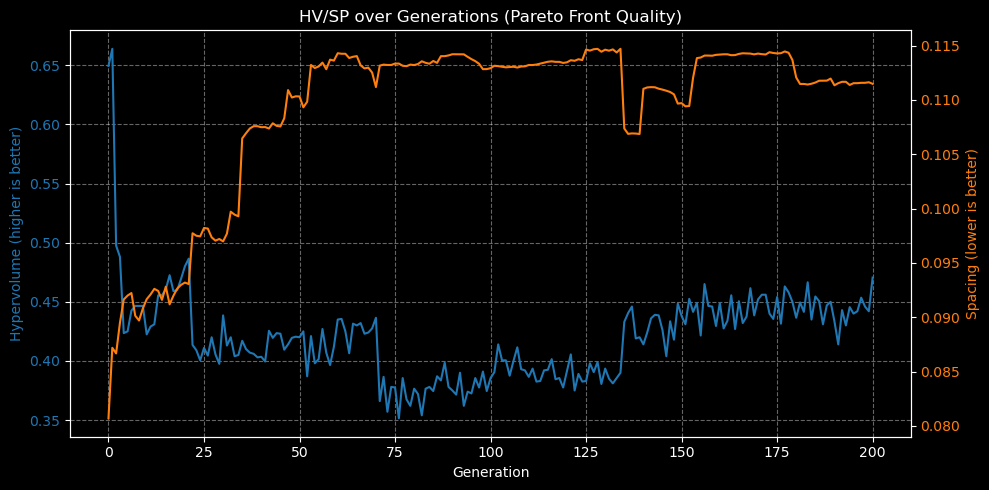


【算法性能指标】(基于固定基准的最终代结果)
Hypervolume (HV): 0.4705
Spacing (SP):     0.1115

【四维度策略优选结果】
            Ann_Return Max_Drawdown Factor_Score Num_Stocks Sharpe_Proxy
Best Sharpe      6.43%        0.55%       0.1213         30        11.77
Min Risk         4.71%        0.50%       0.1211         30         9.47
Max Return       8.30%        4.25%       0.4890         10         1.95
Max Score        8.30%        4.25%       0.4890         10         1.95

>>> 策略详情: Best Sharpe
   持仓数量: 19
   平均得分: 0.2591
Stock_Code Stock_Name            Industry  Factor_Score
    601872       招商轮船            G55水上运输业      1.094615
    600183       生益科技 C39计算机、通信和其他电子设备制造业      1.094615
    300308       中际旭创 C39计算机、通信和其他电子设备制造业      1.094615
    002384       东山精密 C39计算机、通信和其他电子设备制造业      1.021027
    603799       华友钴业     C32有色金属冶炼和压延加工业      0.147082
    000975       山金国际         B09有色金属矿采选业      0.111013
    600089       特变电工       C38电气机械和器材制造业      0.096179
    300274       阳光电源       C38电气机械和器材制造业      0.

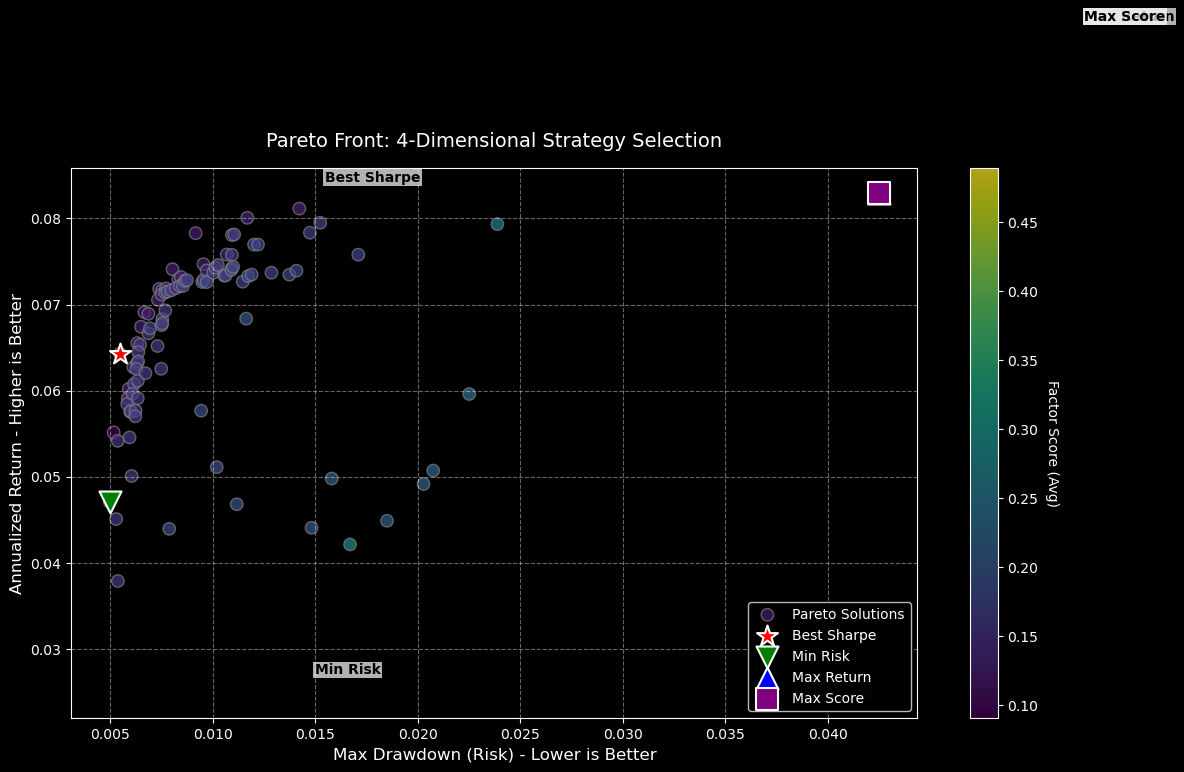


最大收益优选组合 (Top 5 by Ann_Return)
   Ann_Return Max_Drawdown Factor_Score Num_Stocks Sharpe_Proxy
98      8.30%        4.25%       0.4890         10         1.95
81      8.12%        1.42%       0.1312         30         5.71
69      8.01%        1.17%       0.1340         29         6.86
86      7.95%        1.52%       0.1723         29         5.22
90      7.93%        2.39%       0.2591         19         3.32

--------------------------------------------------
[Max Return Rank #1] Ann_Return=8.30%, MaxDD=4.25%, Score=0.4890, Num=10
Stock_Code            Industry    Score
    000975         B09有色金属矿采选业 0.111013
    603799     C32有色金属冶炼和压延加工业 0.147082
    688082          C35专用设备制造业 0.042967
    300274       C38电气机械和器材制造业 0.056983
    600089       C38电气机械和器材制造业 0.096179
    000977 C39计算机、通信和其他电子设备制造业 0.131305
    002384 C39计算机、通信和其他电子设备制造业 1.021027
    300308 C39计算机、通信和其他电子设备制造业 1.094615
    600183 C39计算机、通信和其他电子设备制造业 1.094615
    601872            G55水上运输业 1.094615

------------------

In [8]:
# ==========================================
# 第四部分：主程序执行 (Main Execution)
# 功能：运行优化，输出报表
# ==========================================
if __name__ == "__main__":

    try:
        data = load_and_process_data()
        ret_mat, score_ser, sec_ser, valid_codes, sec_names, code_to_name = data

        # 2. 执行优化
        optimizer = NSGA3_Optimizer(ret_mat, score_ser, sec_ser)
        final_pop, final_objs, df_hv_sp = optimizer.run()

        # --- 【优化代码开始】生成质量指标汇总 CSV ---
        # 直接提取最后一代的指标，避免重复计算和随机误差
        final_metrics = df_hv_sp.iloc[-1]

        # 构建符合您格式要求的 DataFrame
        df_quality = pd.DataFrame([{
            "HV": final_metrics["hv"],
            "SP": final_metrics["sp"],
            "front_size": int(final_metrics["front_size"]),
            "ref_point": "1.100,1.100,1.100",  # 对应代码中固定的参考点
            "hv_samples": 2000  # 对应代码中固定的采样数
        }])

        # 导出文件
        df_quality.to_csv("nsga3_front_quality_metrics.csv", index=False, encoding="utf-8-sig")
        print("已导出：nsga3_front_quality_metrics.csv (基于最终代结果)")

        # 【新增】导出每代 HV/SP
        df_hv_sp.to_csv("nsga3_hv_sp_history.csv", index=False, encoding="utf-8-sig")
        print("已导出：nsga3_hv_sp_history.csv")

        # 【新增】画 HV / SP 曲线
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(df_hv_sp["gen"], df_hv_sp["hv"], color="tab:blue", label="HV")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Hypervolume (higher is better)", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")
        ax1.grid(True, linestyle="--", alpha=0.4)

        ax2 = ax1.twinx()
        ax2.plot(df_hv_sp["gen"], df_hv_sp["sp"], color="tab:orange", label="SP")
        ax2.set_ylabel("Spacing (lower is better)", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")

        plt.title("HV/SP over Generations (Pareto Front Quality)")
        fig.tight_layout()
        plt.show()

        # 3. 结果整理
        df_result = pd.DataFrame({
            'Ann_Return': final_objs[:, 0],
            'Max_Drawdown': final_objs[:, 1],
            'Factor_Score': final_objs[:, 2],
            'Num_Stocks': np.sum(final_pop, axis=1)
        })

        # 计算夏普代理 (收益/回撤)
        df_result['Sharpe_Proxy'] = df_result['Ann_Return'] / (df_result['Max_Drawdown'] + 1e-6)
        df_result = df_result.sort_values('Sharpe_Proxy', ascending=False).reset_index(drop=True)

        final_metrics = df_hv_sp.iloc[-1]

        print("\n" + "=" * 40)
        print("【算法性能指标】(基于固定基准的最终代结果)")
        print(f"Hypervolume (HV): {final_metrics['hv']:.4f}")
        print(f"Spacing (SP):     {final_metrics['sp']:.4f}")
        print("=" * 40)

        # ==========================================
        # 4. 四维度优选解定位
        # ==========================================
        # 策略 A: 夏普最优 (平衡型)
        idx_sharpe = df_result['Sharpe_Proxy'].idxmax()

        # 策略 B: 最小回撤 (保守型)
        idx_min_risk = df_result['Max_Drawdown'].idxmin()

        # 策略 C: 最大收益 (激进型)
        idx_max_ret = df_result['Ann_Return'].idxmax()

        # 策略 D: 最大因子得分 (风格型) - 新增
        idx_max_score = df_result['Factor_Score'].idxmax()

        strategies = {
            "Best Sharpe": {"idx": idx_sharpe, "color": "red", "marker": "*", "file_suffix": "sharpe"},
            "Min Risk": {"idx": idx_min_risk, "color": "green", "marker": "v", "file_suffix": "min_risk"},
            "Max Return": {"idx": idx_max_ret, "color": "blue", "marker": "^", "file_suffix": "max_return"},
            "Max Score": {"idx": idx_max_score, "color": "purple", "marker": "s", "file_suffix": "max_score"}
        }

        print("\n" + "=" * 60)
        print("【四维度策略优选结果】")
        print("=" * 60)

        # 打印摘要表
        selected_indices = [meta["idx"] for meta in strategies.values()]
        selected_rows = df_result.loc[selected_indices].copy()
        selected_rows.index = strategies.keys()

        print(selected_rows[['Ann_Return', 'Max_Drawdown', 'Factor_Score', 'Num_Stocks', 'Sharpe_Proxy']].to_string(
            formatters={
                'Ann_Return': '{:.2%}'.format,
                'Max_Drawdown': '{:.2%}'.format,
                'Factor_Score': '{:.4f}'.format,
                'Num_Stocks': '{:.0f}'.format,
                'Sharpe_Proxy': '{:.2f}'.format
            }))


        # ==========================================
        # 5. 持仓详情提取与导出
        # ==========================================
        def process_portfolio(name, z_vec, scores, sectors, valid_codes, sec_names, file_suffix):
            print(f"\n>>> 策略详情: {name}")
            sel_idx = np.where(z_vec == 1)[0]

            df_holdings = pd.DataFrame({
                'Stock_Code': valid_codes[sel_idx],
                # 假设 code_to_name 在 load_data 返回值中 (需确保 load_data 返回了 code_to_name)
                # 如果没有，请注释掉下面这行
                'Stock_Name': [code_to_name.get(c, "Unknown") for c in valid_codes[sel_idx]],
                'Industry': sec_names[sectors[sel_idx]],
                'Factor_Score': scores[sel_idx]
            })

            # 统计信息
            print(f"   持仓数量: {len(df_holdings)}")
            print(f"   平均得分: {df_holdings['Factor_Score'].mean():.4f}")

            # 排序并显示前10只（按得分）
            print(df_holdings.sort_values('Factor_Score', ascending=False).head(10).to_string(index=False))
            if len(df_holdings) > 10:
                print(f"   ... (共 {len(df_holdings)} 只，完整列表已导出)")

            # 导出 CSV
            filename = f"nsga3_holdings_{file_suffix}.csv"
            df_holdings.to_csv(filename, index=False, encoding="utf-8-sig")
            print(f"   [已导出]: {filename}")


        # 循环处理每个策略
        for name, meta in strategies.items():
            original_pop_idx = meta["idx"]
            best_z = final_pop[original_pop_idx]

            process_portfolio(
                name,
                best_z,
                score_ser.values,
                sec_ser.values,
                valid_codes,
                sec_names,
                meta["file_suffix"]
            )

        # ==========================================
        # 6. 可视化展现 (四点标记)
        # ==========================================
        plt.figure(figsize=(12, 8))

        # 绘制所有帕累托点 (底图)
        sc = plt.scatter(df_result['Max_Drawdown'], df_result['Ann_Return'], c=df_result['Factor_Score'],
                         cmap='viridis', s=80, alpha=0.7, edgecolors='grey', label='Pareto Solutions')
        cbar = plt.colorbar(sc)
        cbar.set_label('Factor Score (Avg)', rotation=270, labelpad=15)

        # 标记四个特殊点
        for name, meta in strategies.items():
            row = df_result.loc[meta["idx"]]
            # 绘制大点
            plt.scatter(row['Max_Drawdown'], row['Ann_Return'],
                        color=meta["color"], marker=meta["marker"], s=250,
                        label=name, zorder=10, edgecolors='white', linewidth=1.5)

            # 添加带偏移的文字标签 (防止重叠)
            # 简单的交替偏移逻辑
            y_offset = 0.02 if meta["idx"] % 2 == 0 else -0.02
            plt.text(row['Max_Drawdown'] + 0.01, row['Ann_Return'] + y_offset, name,
                     fontsize=10, fontweight='bold', color='black',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

        plt.xlabel('Max Drawdown (Risk) - Lower is Better', fontsize=12)
        plt.ylabel('Annualized Return - Higher is Better', fontsize=12)
        plt.title('Pareto Front: 4-Dimensional Strategy Selection', fontsize=14, pad=15)
        plt.legend(loc='lower right', frameon=True, framealpha=0.9, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

        # ------------------------------
        # 【新增输出】按最大收益(Ann_Return)选择 Top N 解
        # 不改变你原来的输出，只是追加一个“收益优先”榜单
        # ------------------------------
        TOP_N_BY_RETURN = 5
        PRINT_HOLDINGS_FOR_TOP_RETURN = True  # 若只想看表，不想打印持仓，改 False

        df_top_ret = (
            df_result
            .replace([np.inf, -np.inf], np.nan)
            .dropna(subset=["Ann_Return", "Max_Drawdown", "Factor_Score"])
            .sort_values("Ann_Return", ascending=False)
            .head(TOP_N_BY_RETURN)
            .copy()
        )

        print("\n" + "=" * 50)
        print(f"最大收益优选组合 (Top {TOP_N_BY_RETURN} by Ann_Return)")
        print("=" * 50)
        print(df_top_ret.to_string(formatters={
            'Ann_Return': '{:.2%}'.format,
            'Max_Drawdown': '{:.2%}'.format,
            'Factor_Score': '{:.4f}'.format,
            'Num_Stocks': '{:.0f}'.format,
            'Sharpe_Proxy': '{:.2f}'.format
        }))
        best_profile_stocks = []

        if PRINT_HOLDINGS_FOR_TOP_RETURN:
            for rank, row in enumerate(df_top_ret.itertuples(index=False), start=1):
                # 用目标向量在 final_objs 中做最近邻匹配，得到对应的 z
                #（与你下面“最佳策略持仓详情”的做法一致，确保不依赖 index 对齐）
                target = np.array([row.Ann_Return, row.Max_Drawdown, row.Factor_Score], dtype=float)
                d = np.sum((final_objs - target) ** 2, axis=1)
                idx = int(np.argmin(d))
                z = final_pop[idx]

                stocks_k = valid_codes[z == 1]
                best_profile_stocks.append(stocks_k)
                sectors_k = sec_names[sec_ser[z == 1]]
                scores_k = score_ser[z == 1]

                df_holdings_k = pd.DataFrame({
                    "Stock_Code": stocks_k,
                    "Industry": sectors_k,
                    "Score": scores_k.values
                }).sort_values("Industry")

                print("\n" + "-" * 50)
                print(f"[Max Return Rank #{rank}] Ann_Return={row.Ann_Return:.2%}, "
                      f"MaxDD={row.Max_Drawdown:.2%}, Score={row.Factor_Score:.4f}, "
                      f"Num={int(row.Num_Stocks)}")
                print(df_holdings_k.to_string(index=False))

    except Exception as e:
        print(f"程序运行出错: {e}")
        import traceback

        traceback.print_exc()

回测
======
在样本外时间验证最佳持仓组合的真实效果

In [9]:
# ==========================================
# 7. 获取四个维度的持仓代码列表 (List of Lists)
# ==========================================

# 定义提取顺序 (与您的要求一致)
# 0: 夏普最优, 1: 最大收益, 2: 最小风险, 3: 最大因子得分
# 注意：这里的 Key 必须与上面 strategies 字典中的 Key 保持一致
target_order = ["Best Sharpe", "Max Return", "Min Risk", "Max Score"]

# 初始化结果列表
optimal_stock_codes = []

print("\n" + "=" * 60)
print("【正在生成持仓代码列表...】")

for i, name in enumerate(target_order):
    # 1. 获取该策略在最终种群中的索引
    pop_idx = strategies[name]["idx"]

    # 2. 获取对应的 0-1 决策向量
    z_vec = final_pop[pop_idx]

    # 3. 提取为 1 的位置，并映射回股票代码
    sel_idx = np.where(z_vec == 1)[0]
    codes_list = valid_codes[sel_idx].tolist()  # 转为 Python list

    # 4. 存入大列表
    optimal_stock_codes.append(codes_list)

    print(f"  列表索引 [{i}] - {name}: 提取了 {len(codes_list)} 只股票代码")

print("=" * 60)


【正在生成持仓代码列表...】
  列表索引 [0] - Best Sharpe: 提取了 19 只股票代码
  列表索引 [1] - Max Return: 提取了 30 只股票代码
  列表索引 [2] - Min Risk: 提取了 30 只股票代码
  列表索引 [3] - Max Score: 提取了 30 只股票代码



==================== 正在回测: Best Sharpe ====================
正在获取 19 只股票数据...
[1/19] 000792 成功
[2/19] 000975 成功
[3/19] 002384 成功
[4/19] 002475 成功
[5/19] 002709 成功
[6/19] 300274 成功
[7/19] 300308 成功
[8/19] 600089 成功
[9/19] 600183 成功
[10/19] 600426 成功
[11/19] 600489 成功
[12/19] 600547 成功
[13/19] 601698 成功
[14/19] 601872 成功
[15/19] 601888 成功
[16/19] 603799 成功
[17/19] 603993 成功
[18/19] 605117 成功
[19/19] 688082 成功


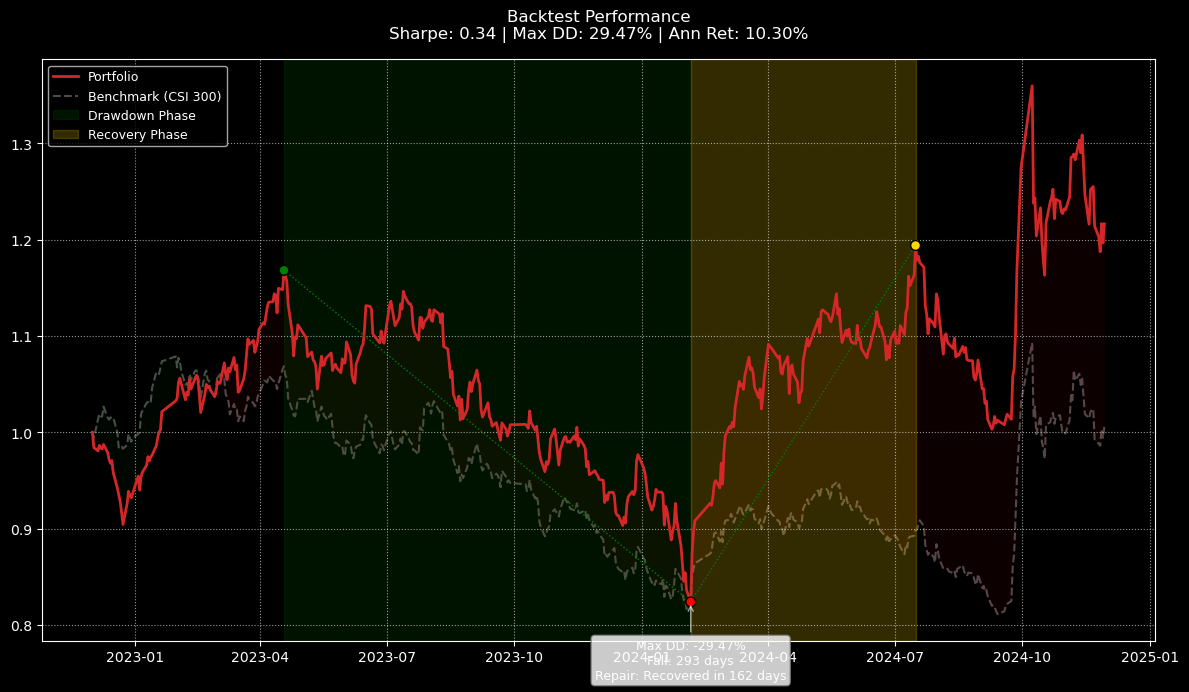


==================== 正在回测: Max Return ====================
正在获取 30 只股票数据...
[1/30] 000301 成功
[2/30] 000425 成功
[3/30] 000625 成功
[4/30] 000975 成功
[5/30] 000977 成功
[6/30] 002352 成功
[7/30] 002384 成功
[8/30] 002594 成功
[9/30] 002920 成功
[10/30] 300308 成功
[11/30] 600029 成功
[12/30] 600031 成功
[13/30] 600183 成功
[14/30] 600426 成功
[15/30] 600918 成功
[16/30] 601006 成功
[17/30] 601066 成功
[18/30] 601166 成功
[19/30] 601601 成功
[20/30] 601668 成功
[21/30] 601698 成功
[22/30] 601868 成功
[23/30] 601872 成功
[24/30] 601916 成功
[25/30] 601995 成功
[26/30] 603195 成功
[27/30] 603799 成功
[28/30] 603993 成功
[29/30] 605117 成功
[30/30] 688082 成功


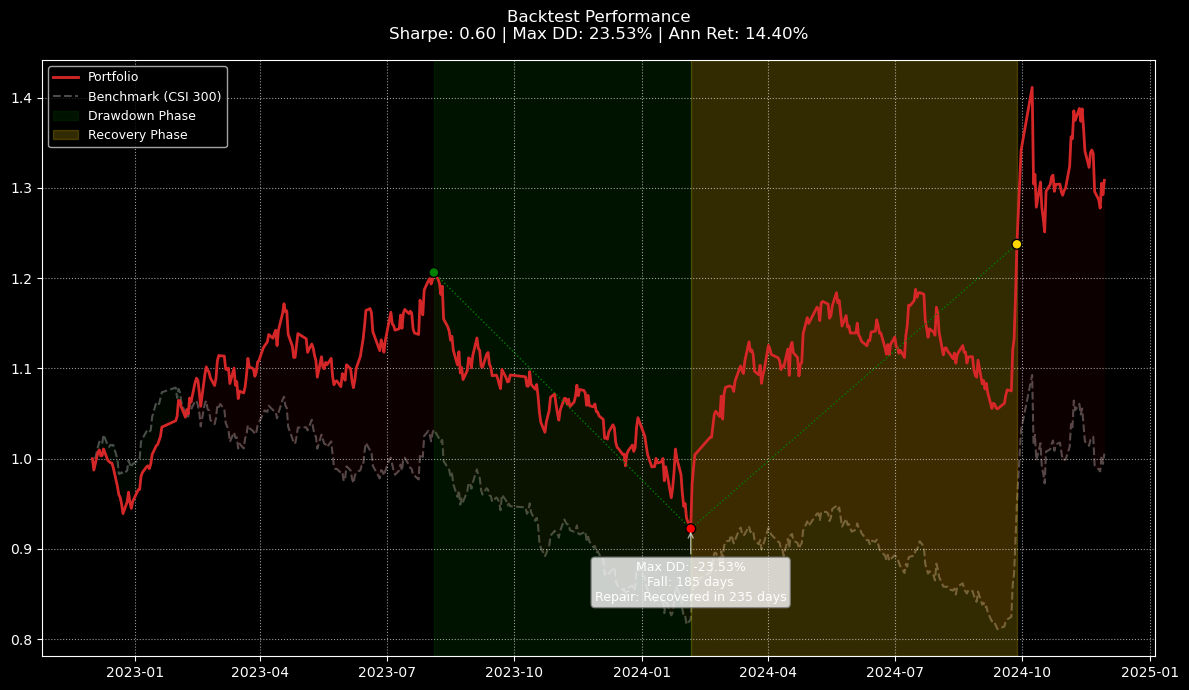


==================== 正在回测: Min Risk ====================
正在获取 30 只股票数据...
[1/30] 000157 成功
[2/30] 000301 成功
[3/30] 000425 成功
[4/30] 000625 成功
[5/30] 000975 成功
[6/30] 000977 成功
[7/30] 002352 成功
[8/30] 002384 成功
[9/30] 002648 成功
[10/30] 002920 成功
[11/30] 300124 成功
[12/30] 300308 成功
[13/30] 600029 成功
[14/30] 600089 成功
[15/30] 600183 成功
[16/30] 600426 成功
[17/30] 601066 成功
[18/30] 601166 成功
[19/30] 601601 成功
[20/30] 601698 成功
[21/30] 601788 成功
[22/30] 601868 成功
[23/30] 601872 成功
[24/30] 601995 成功
[25/30] 603799 成功
[26/30] 603993 成功
[27/30] 605117 成功
[28/30] 688012 成功
[29/30] 688082 成功
[30/30] 688187 成功


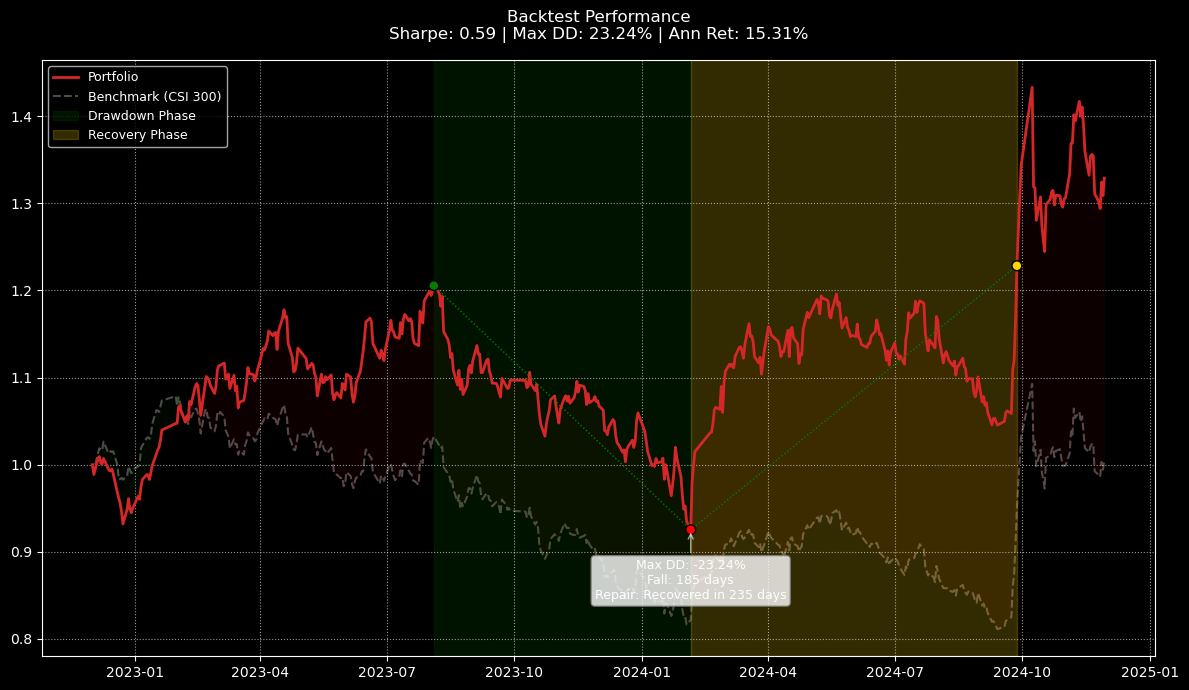


==================== 正在回测: Max Score ====================
正在获取 30 只股票数据...
[1/30] 000301 成功
[2/30] 000425 成功
[3/30] 000625 成功
[4/30] 000975 成功
[5/30] 000977 成功
[6/30] 002352 成功
[7/30] 002384 成功
[8/30] 002594 成功
[9/30] 002920 成功
[10/30] 300308 成功
[11/30] 600029 成功
[12/30] 600031 成功
[13/30] 600183 成功
[14/30] 600426 成功
[15/30] 600918 成功
[16/30] 601006 成功
[17/30] 601066 成功
[18/30] 601166 成功
[19/30] 601601 成功
[20/30] 601668 成功
[21/30] 601698 成功
[22/30] 601868 成功
[23/30] 601872 成功
[24/30] 601916 成功
[25/30] 601995 成功
[26/30] 603195 成功
[27/30] 603799 成功
[28/30] 603993 成功
[29/30] 605117 成功
[30/30] 688082 成功


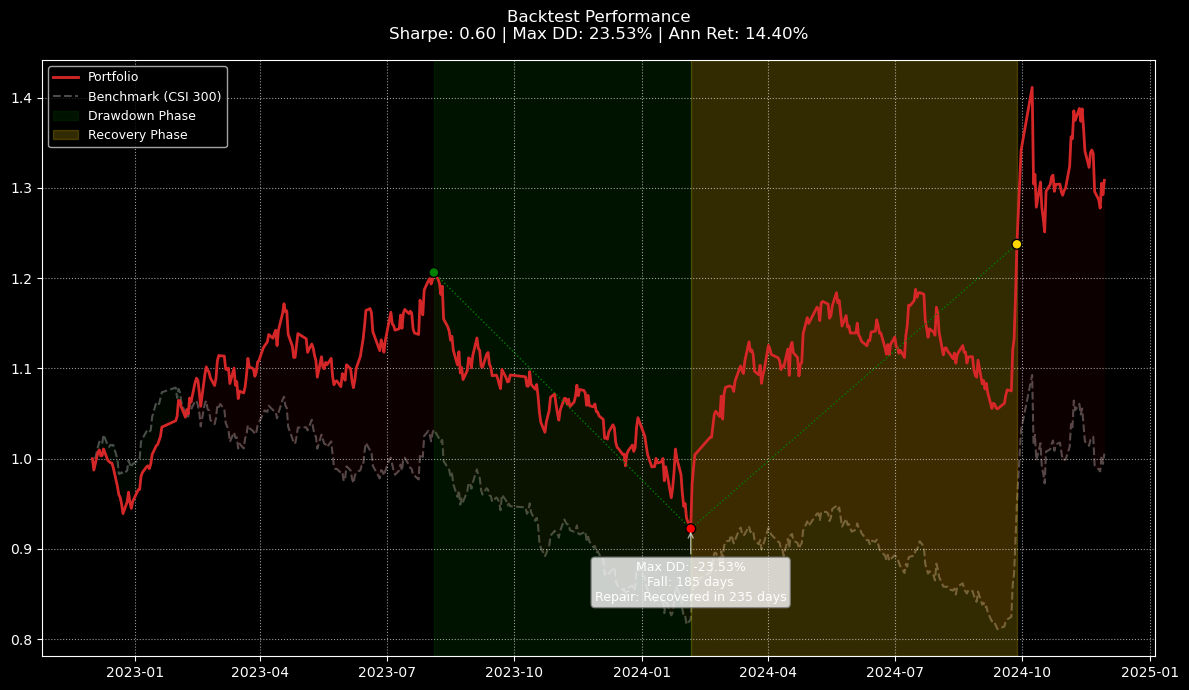


【所有策略样本外回测结果对比】
             Total Return  Annual Return  Sharpe Ratio  Max Drawdown DD Start Date DD Valley Date DD Recovery Date  Is Recovered  Recovery Days
Strategy                                                                                                                                       
Best Sharpe      0.216326       0.103020      0.339373      0.294704    2023-04-18     2024-02-05       2024-07-16          True            162
Max Return       0.308348       0.144041      0.595034      0.235297    2023-08-04     2024-02-05       2024-09-27          True            235
Min Risk         0.329010       0.153052      0.589595      0.232416    2023-08-04     2024-02-05       2024-09-27          True            235
Max Score        0.308348       0.144041      0.595034      0.235297    2023-08-04     2024-02-05       2024-09-27          True            235


In [10]:

from backtest import AkShareBacktestEngine

# 1. 初始化回测引擎
engine = AkShareBacktestEngine(risk_free_rate=0.02)

# 2. 准备一个列表来存储所有策略的回测结果
all_metrics = []

# 3. 循环遍历每个策略的持仓列表
# target_order 在上一个单元格中已经定义
for i, stock_list in enumerate(optimal_stock_codes):
    strategy_name = target_order[i]
    print(f"\n{'=' * 20} 正在回测: {strategy_name} {'=' * 20}")

    # 清理股票代码 (与您原来的逻辑保持一致)
    stocks_to_backtest = (
        pd.Series(stock_list, dtype="string")
        .astype(str).str.strip()
        .str.replace(r"\.SZ$|\.SH$", "", regex=True)
        .str.zfill(6)
        .tolist()
    )

    # 检查股票列表是否为空
    if not stocks_to_backtest:
        print(f"策略 '{strategy_name}' 持仓为空，跳过回测。")
        continue

    # 4. 执行回测
    # 注意：这里使用了样本外的时间段 (2022-12-01 到 2024-11-30)
    # 这个时间段在您的优化周期 (2024-12-02 开始) 之前，是真实有效的样本外测试
    metrics = engine.run(
        stock_codes=stocks_to_backtest,
        start_date="2022-12-01",
        end_date="2024-11-30",
    )

    # 5. 存储结果，并添加策略名称
    metrics['Strategy'] = strategy_name
    all_metrics.append(metrics)

# 6. 将所有结果合并成一个 DataFrame 并展示
if all_metrics:
    df_all_metrics = pd.DataFrame(all_metrics).set_index('Strategy')
    print("\n" + "=" * 60)
    print("【所有策略样本外回测结果对比】")
    print("=" * 60)
    print(df_all_metrics.to_string())
else:
    print("没有可用的回测结果。")

单独验证score分数与一年后收益的相关性
== == =

正在获取 30 只股票数据...
[1/30] 002384 成功
[2/30] 002648 成功
[3/30] 002920 成功
[4/30] 300308 成功
[5/30] 300316 成功
[6/30] 000301 成功
[7/30] 000425 成功
[8/30] 600029 成功
[9/30] 600031 成功
[10/30] 600089 成功
[11/30] 600183 成功
[12/30] 600522 成功
[13/30] 600547 成功
[14/30] 600570 成功
[15/30] 601006 成功
[16/30] 601066 成功
[17/30] 601100 成功
[18/30] 601698 成功
[19/30] 601899 成功
[20/30] 601995 成功
[21/30] 603993 成功
[22/30] 605117 成功
[23/30] 000625 成功
[24/30] 688012 成功
[25/30] 688082 成功
[26/30] 688187 成功
[27/30] 688223 成功
[28/30] 000792 成功
[29/30] 000876 成功
[30/30] 000977 成功


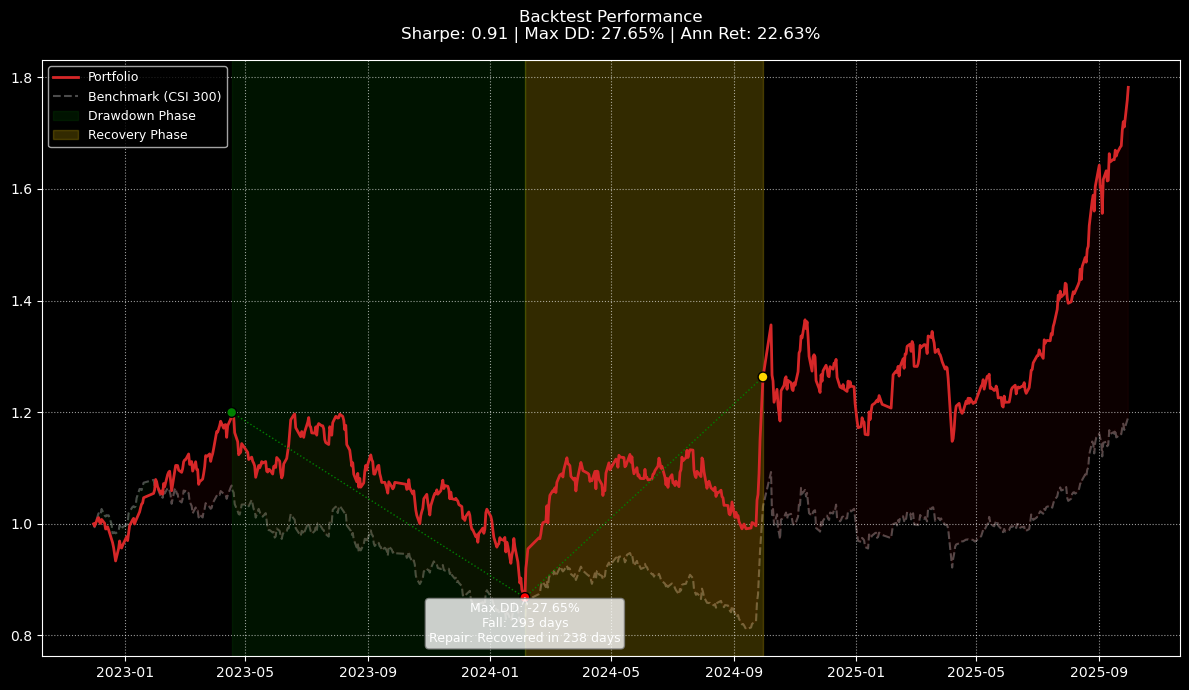

In [16]:
stocks = (
    pd.Series(best_profile_stocks[:30])
    .astype(str).str.strip()
    .str.replace(r"\.SZ$|\.SH$", "", regex=True)
    .str.zfill(6)
)

engine = AkShareBacktestEngine(risk_free_rate=0.02)  # create an instance
metrics = engine.run(
    stock_codes=stocks.tolist(),  # optional: pass a plain list instead of a Series
    start_date="2022-12-01",
    end_date="2025-10-01",
)

单独验证score分数与一年后收益的相关性
=====
额外证明了score的有效设计

对比试验，使用哪些其他算法，未改进的
======